## Unsupervised Learning Project: Trade & Ahead

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries, data, and creating functions

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [3]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [6]:
#reading csv file into a pandas Dataframe
ta = pd.read_csv('/content/drive/MyDrive/Unsupervised Learning/stock_data.csv')
# copying data to another varaible to preserve original data
df = ta.copy()

## Data Overview

In [7]:
# print a sample of five rows randomly selected from the training data
df.sample(n=5)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
75,COF,Capital One Financial,Financials,Consumer Finance,72.18,-0.62,1.36,9,99,781000000,4050000000,7.15,566433566.40,10.10,-0.73
199,MAS,Masco Corp.,Industrials,Building Products,28.30,11.64,1.43,263,61,85000000,355000000,1.03,344660194.20,27.48,2.22
214,MPC,Marathon Petroleum,Energy,Oil & Gas Refining & Marketing & Transportation,51.84,11.51,1.99,22,18,-367000000,2852000000,5.29,539130434.80,9.80,5.80
235,OKE,ONEOK,Energy,Oil & Gas Exploration & Production,24.66,-24.12,3.56,73,6,-75150000,244977000,1.17,209382051.30,21.08,-8.03
334,XYL,Xylem Inc.,Industrials,Industrial Conglomerates,36.50,11.01,1.17,16,83,17000000,340000000,1.88,180851063.80,19.41,4.13


In [8]:
df.shape

(340, 15)

- Dataset has 340 rows and 15 columns

In [9]:
# print the data types of the columns within the datset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [10]:
# checking for duplicate values
df.duplicated().sum()

0

- Dataset has no missing or duplicate values
- All columns with dtype object should be dtype category in order to conserve memory

In [11]:
# convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [12]:
# dropping the ticker symbol column, as it does not provide any information
df.drop("Ticker Symbol", axis=1, inplace=True)

In [13]:
# confirm new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Security                      340 non-null    category
 1   GICS Sector                   340 non-null    category
 2   GICS Sub Industry             340 non-null    category
 3   Current Price                 340 non-null    float64 
 4   Price Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash Ratio                    340 non-null    int64   
 8   Net Cash Flow                 340 non-null    int64   
 9   Net Income                    340 non-null    int64   
 10  Earnings Per Share            340 non-null    float64 
 11  Estimated Shares Outstanding  340 non-null    float64 
 12  P/E Ratio                     340 non-null    floa

- The 14 columns have three different dtypes: category(3), float64(7), int64(4)
- All of these dtypes are appropriate for their respective columns


## Exploratory Data Analysis (EDA)

In [14]:
#provide statistical summary of all categorical columns
df.describe(include='category').T

,count,unique,top,freq
Security,340,340,3M Company,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


**GICS Sector**

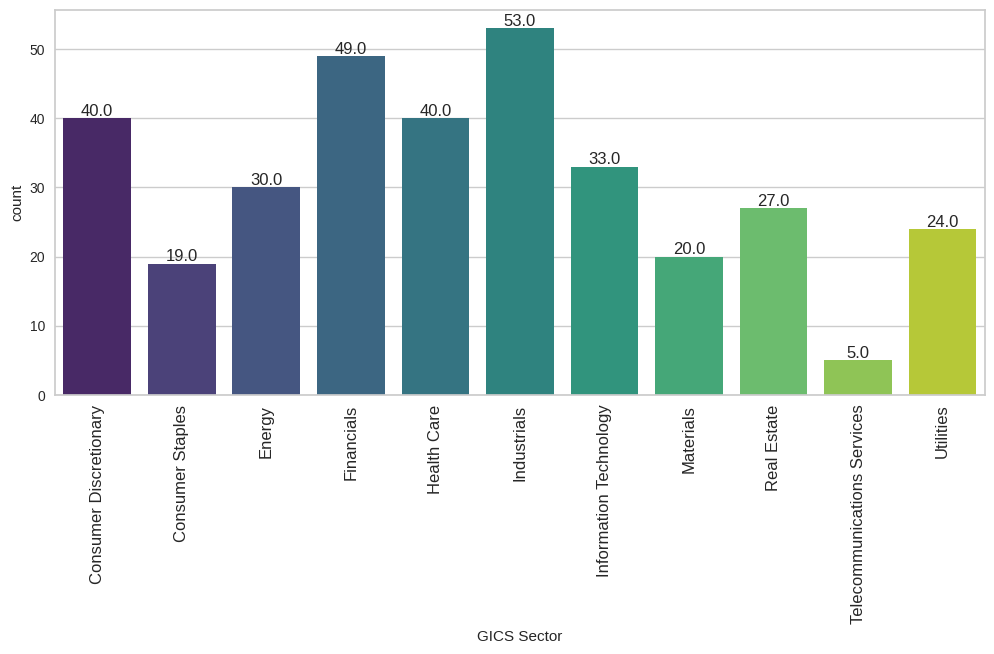

In [15]:
#create labeled barplot of stocks by sector
labeled_barplot(df, 'GICS Sector')

In [16]:
#display the five sectors with the most number of stocks
df["GICS Sector"].value_counts().head(n=5)

Industrials               53
Financials                49
Consumer Discretionary    40
Health Care               40
Information Technology    33
Name: GICS Sector, dtype: int64

- The stocks are drawn from 11 different industrial sectors, with no one sector comprising more than 16% of the dataset
- The top 4 of the 11 sectors (industrials, financials, consumer discretionary, and health care) comprise over half of the total number of stocks

**GICS Sub Industry**

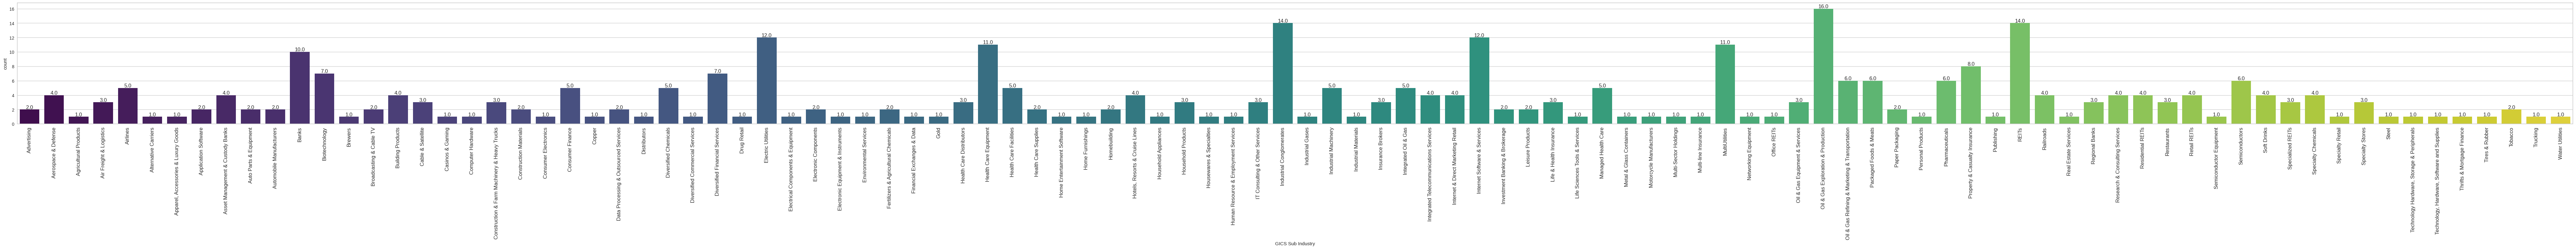

In [17]:
#create labeled barplot of stocks by sub industry
labeled_barplot(df, 'GICS Sub Industry')

In [18]:
#display the five sub industries with the most number of stocks
df['GICS Sub Industry'].value_counts().head(n=5)

Oil & Gas Exploration & Production    16
REITs                                 14
Industrial Conglomerates              14
Internet Software & Services          12
Electric Utilities                    12
Name: GICS Sub Industry, dtype: int64

- The dataset is comprised of stocks from 104 different subindustries, with no subindustry having more than 16 stocks in the dataset
- These observations indicate that the 340 stocks held within the dataset are highly diversified across sectors and subindustries

In [19]:
#provide statistical summary of all numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.00,80.86,98.06,4.50,38.55,59.70,92.88,1274.95
Price Change,340.00,4.08,12.01,-47.13,-0.94,4.82,10.70,55.05
Volatility,340.00,1.53,0.59,0.73,1.13,1.39,1.70,4.58
ROE,340.00,39.60,96.55,1.00,9.75,15.00,27.00,917.00
Cash Ratio,340.00,70.02,90.42,0.00,18.00,47.00,99.00,958.00
Net Cash Flow,340.00,55537620.59,1946365312.18,-11208000000.00,-193906500.00,2098000.00,169810750.00,20764000000.00
Net Income,340.00,1494384602.94,3940150279.33,-23528000000.00,352301250.00,707336000.00,1899000000.00,24442000000.00
Earnings Per Share,340.00,2.78,6.59,-61.20,1.56,2.90,4.62,50.09
Estimated Shares Outstanding,340.00,577028337.75,845849595.42,27672156.86,158848216.10,309675137.80,573117457.32,6159292035.00
P/E Ratio,340.00,32.61,44.35,2.94,15.04,20.82,31.76,528.04


**Numerical Columns**

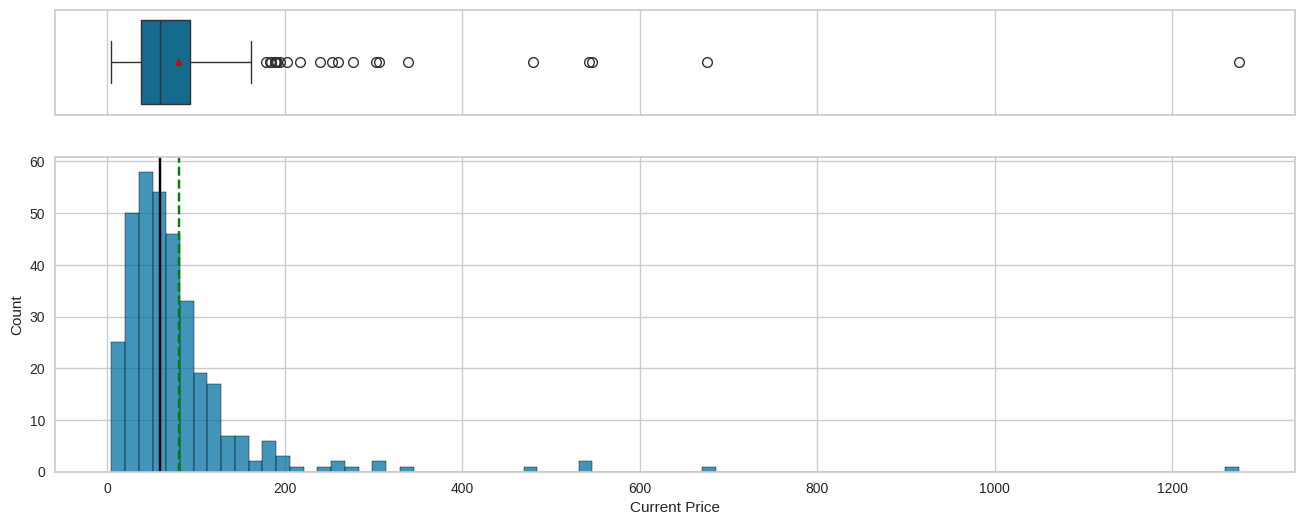

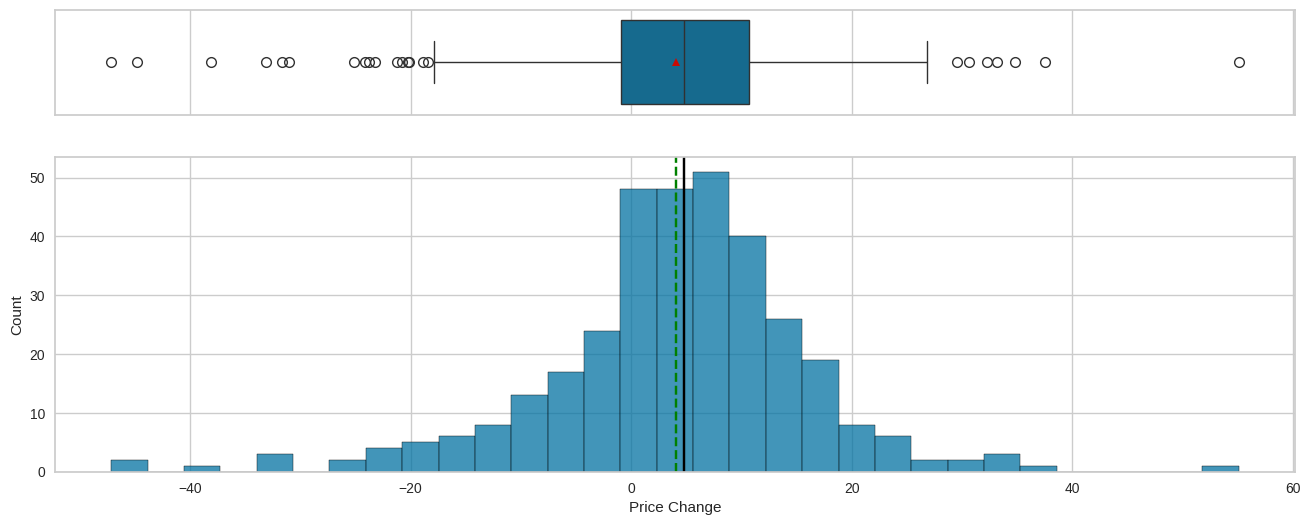

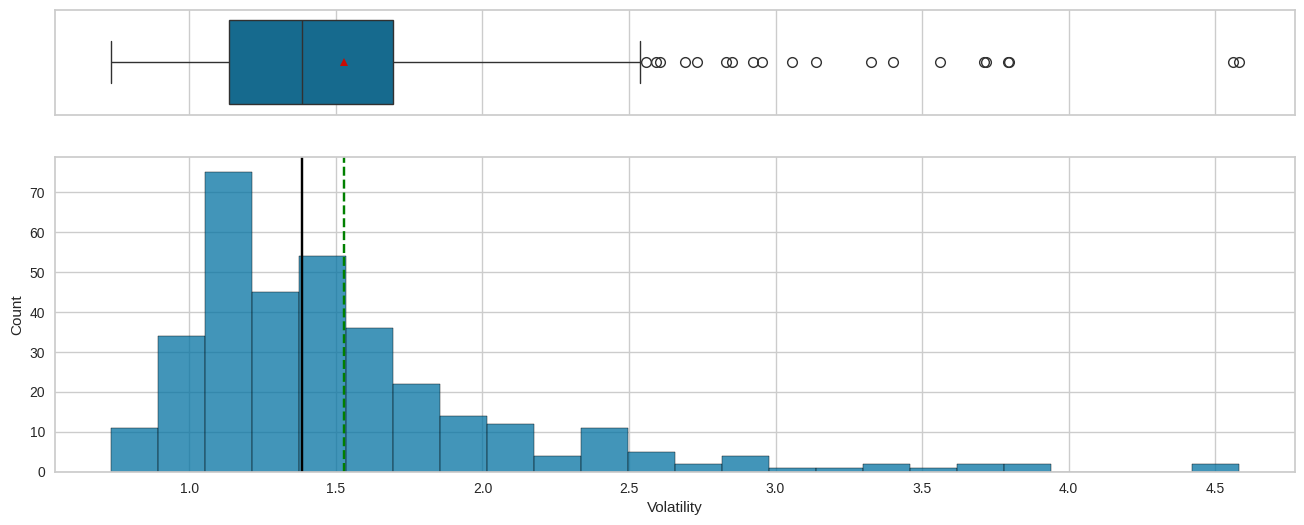

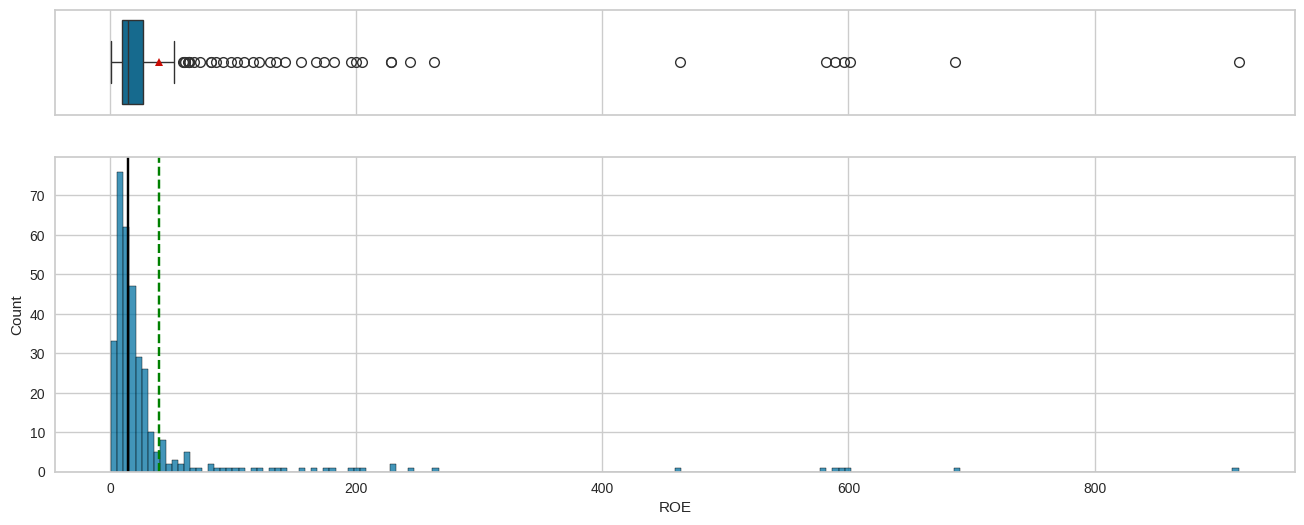

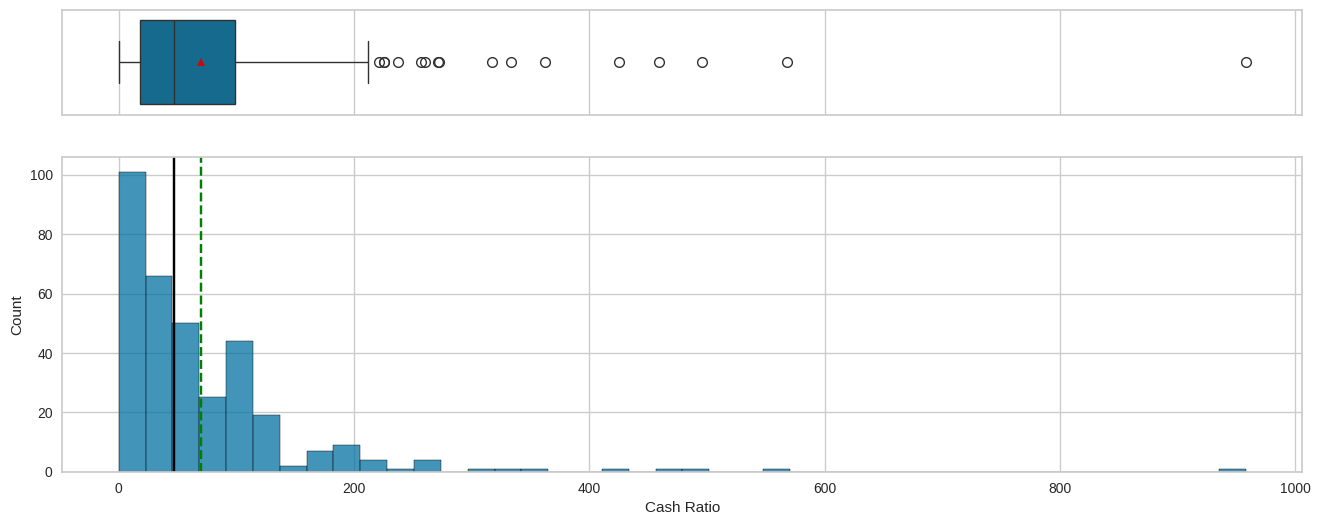

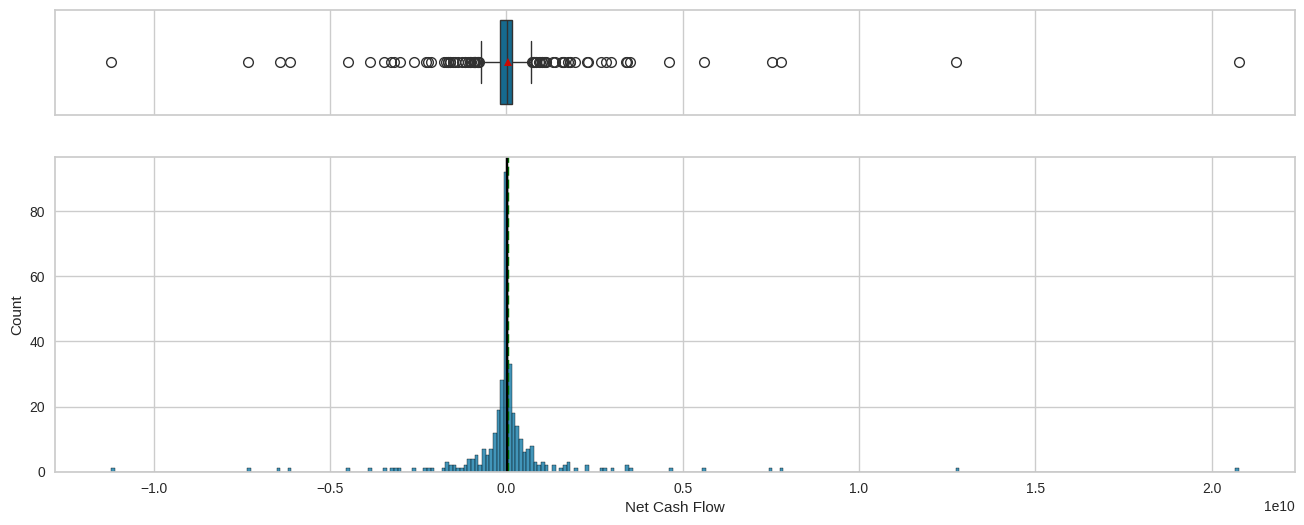

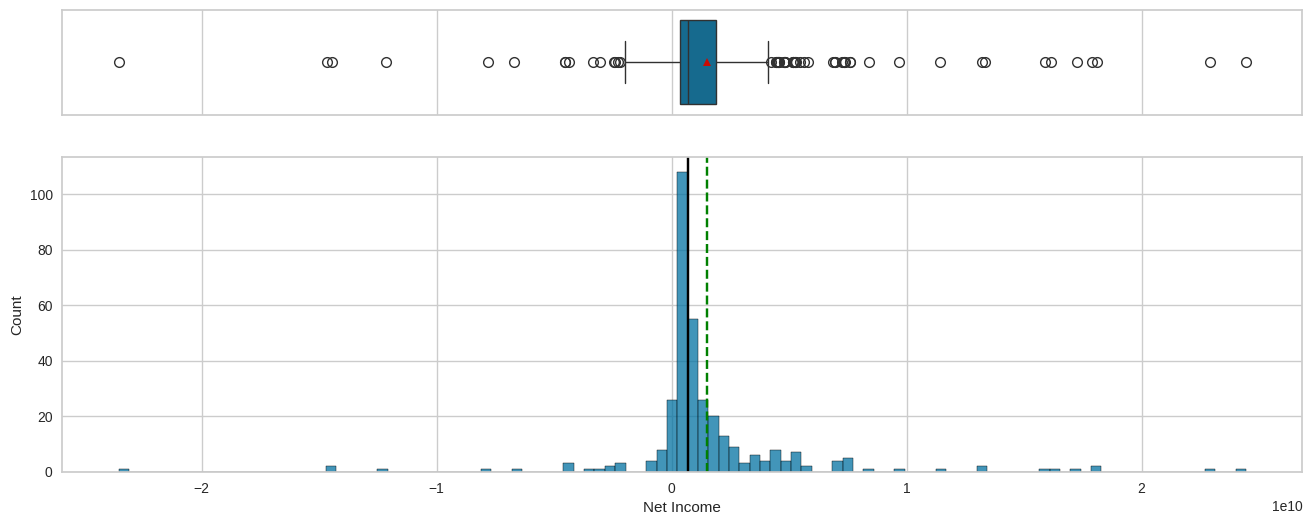

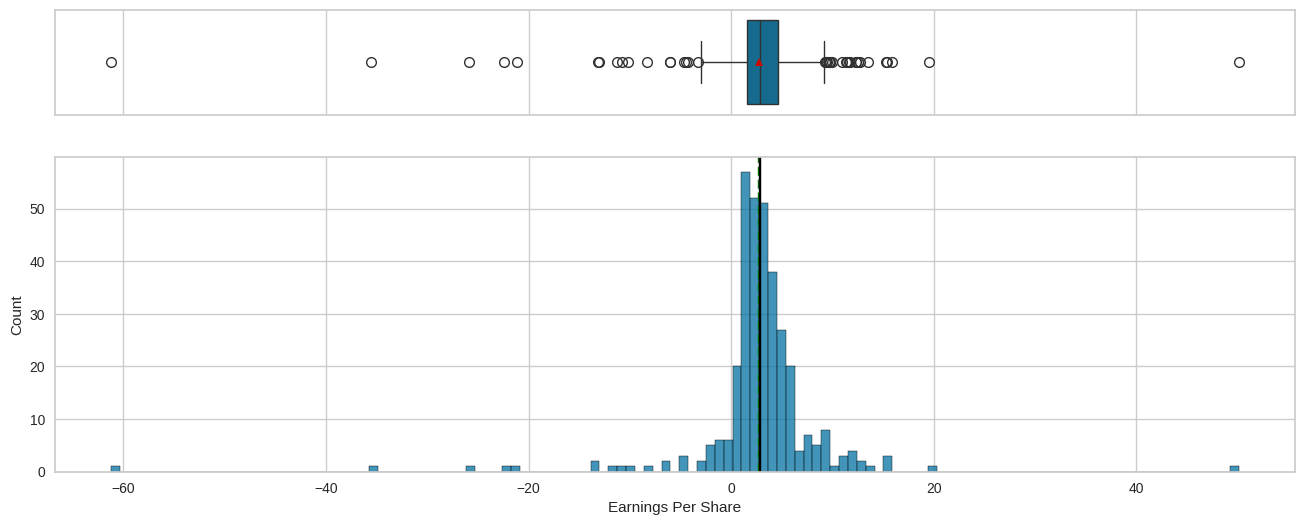

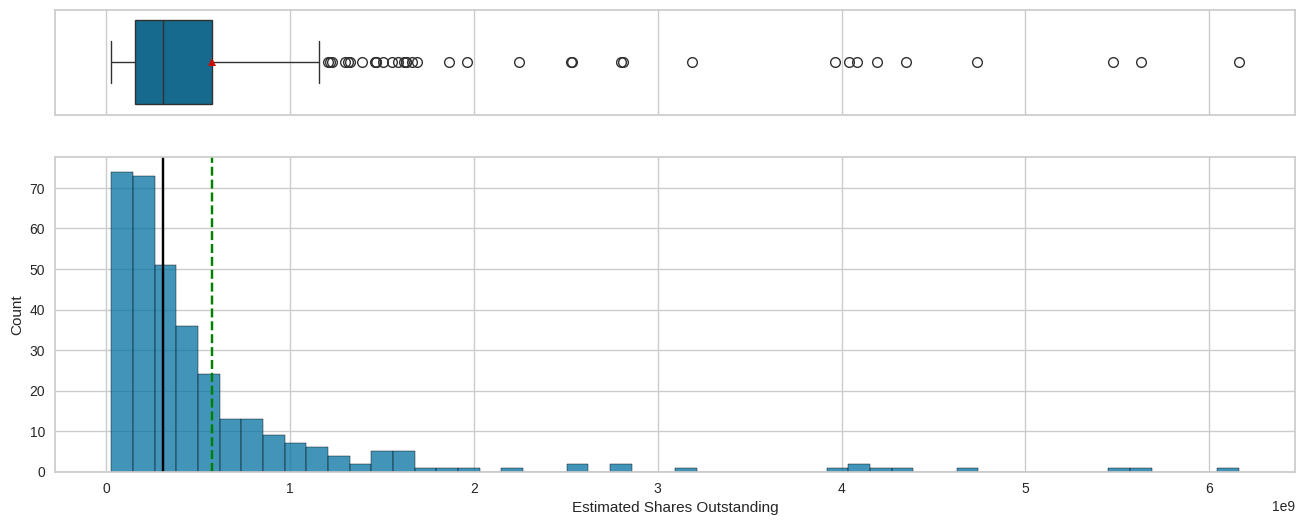

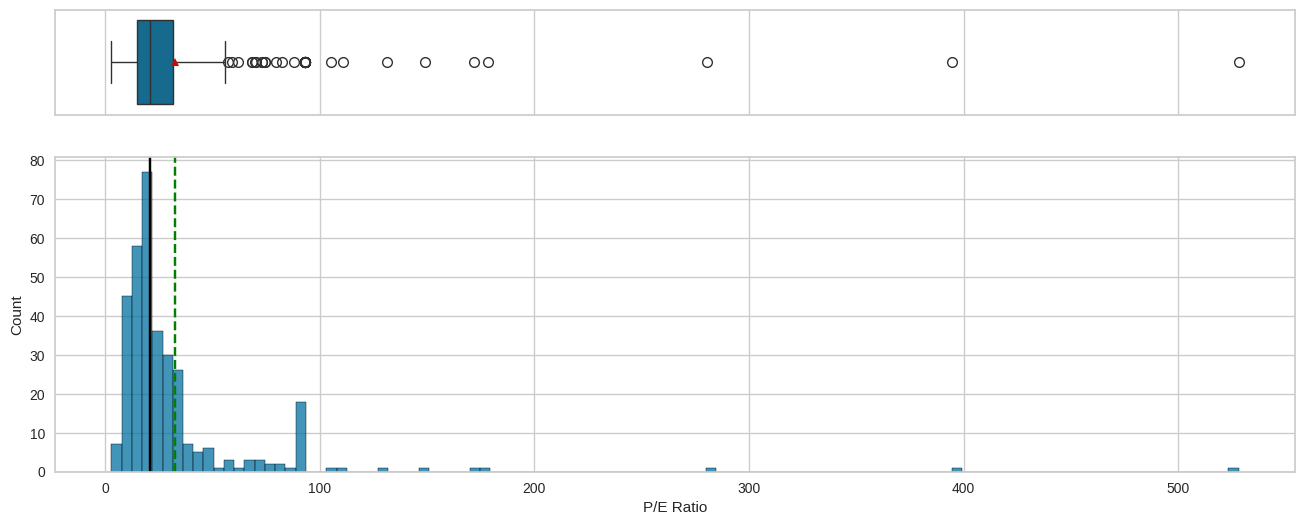

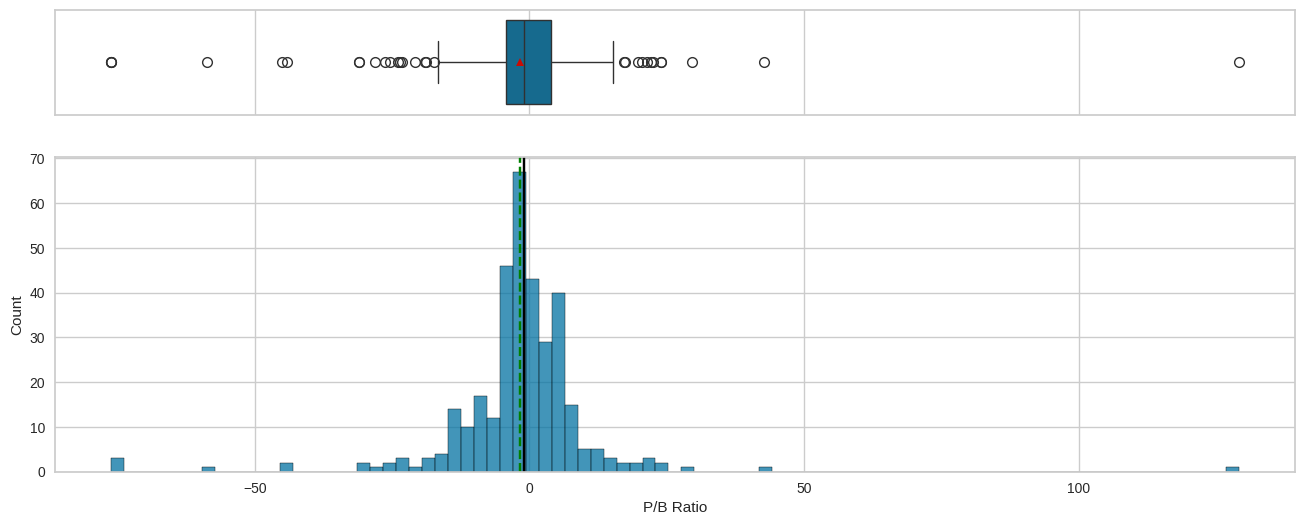

In [20]:
#create list of columns with numerical variables
num_col = df.select_dtypes(include=np.number).columns.tolist()

#display histograms and boxplots for all numerical columns
for col in num_col:
    histogram_boxplot(df, col)

**Current price**
- The distribution is heavily right skewed, with 49 of the 340 stocks having twice the median value of all stocks
- As expected, no stock is listed at less of less than 0 dollars

**Price change**
- The distribution is biased towards lower volatilities, but long tails do exist both for positive and negative price changes
- The most volatile stocks show as low as a 47% decrease to as high as a 55% increase over 13 weeks

**Volatility**
- As expected, the distribution of standard deviations is right skewed and not normal

**Cash Ratio / ROE**
- As expected, both distributions are heavily right skewed and no stock is listed with either metric with a value of less than 0
    - For example,  24 stocks are listed with returns on equity of less than 5 and 25 stocks are listed with returns of over 100 percent

**Net Income / EPS**
- As expected, net income is shown to be right skewed with both long positive and negative tails
    - I.e., most companies generate meager profits, but some are failing and some are highly successful
- 32 companies within the dataset are showing a net income of less than 0 dollars
- EPS, as a derivative of Net Income, shows a similar distribution, with most showing low positive values and a few stocks (34) showing negative values

**Estimated shares outstanding**
- The distribution is highly right skewed, but no stock has a value of outstanding shares that is unrealistic

**P/E and P/B Ratio**
- The distribution of P/E ratios is highly right skewed
    - Interestingly, no stock shows a negative ratio, even though several stocks have a negative EPS and no stock stock has a price listed of less than 0
- The distribution for P/B ratios is mostly centered around 0 but with long positive and negative
    - For example, 175 of the 340 total stocks are shown to below the 25th percentile and above the 75th percentile and
    - Additionally, 31 of the stocks are outliers
    
### Conclusions
- As expected, stocks offer uncertain returns with high upsides, mostly modest returns, and the omnipresent possibility that the value of the stock may become worthless (i.e., the company goes bankrupt)
- All of these variables contain a few or several outliers; however, none of these values appear to be unrealistic given the nature of stock prices and historical expectations

**The stocks of which economic sector have seen the maximum price increase on average?**

In [21]:
df.groupby('GICS Sector')['Price Change'].mean().sort_values()

GICS Sector
Energy                        -10.23
Utilities                       0.80
Industrials                     2.83
Financials                      3.87
Materials                       5.59
Consumer Discretionary          5.85
Real Estate                     6.21
Telecommunications Services     6.96
Information Technology          7.22
Consumer Staples                8.68
Health Care                     9.59
Name: Price Change, dtype: float64

- Stocks within the health care sectors have shown the highest average price increase over the preeceding period

**How are the different variables correlated with each other?**

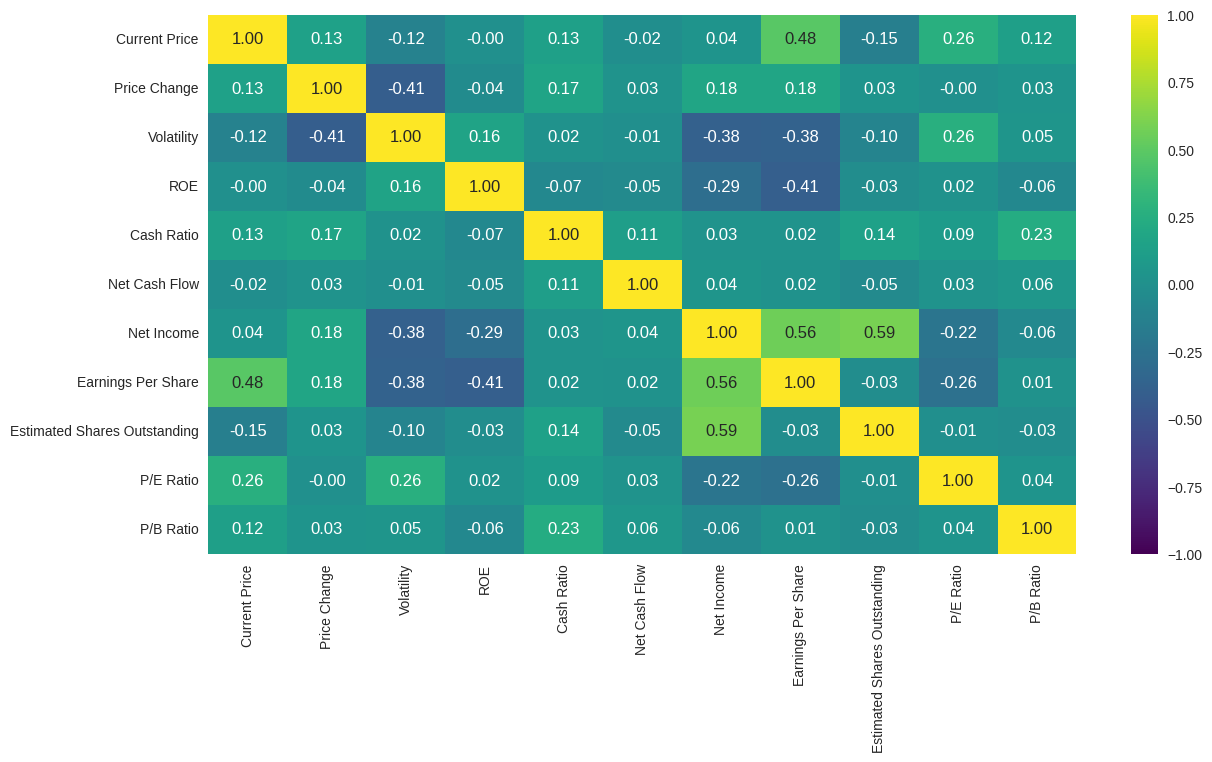

In [22]:
#create correlation heat map for numerical variables
plt.figure(figsize=(14, 7))
sns.heatmap(
    df[num_col].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap='viridis'
)
plt.show()

- Several variables are moderately correlated (+/- .40) with one another
    - Volatility is negatively correlated with price change, i.e., as a stock becomes more volatile, its price is likely dropping
    - Net income is negatively correlayed with volatility, i.e. as a company generates higher net income its price is likely less volatile
    - Net income is also positively correlated with earnings per share (EPS) and estimated shares outstanding
    - EPS is positively correlated with current price, i.e. as a company's EPS rises, its prices is also highly likely to increase
    - EPS is also negatively correlated with ROE, i.e. as a company generates more equity for shareholders, an equivalent amount of net income the following periods will generate a lower return

**Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?**

In [23]:
df.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending=False)

GICS Sector
Information Technology        149.82
Telecommunications Services   117.00
Health Care                   103.78
Financials                     98.59
Consumer Staples               70.95
Energy                         51.13
Real Estate                    50.11
Consumer Discretionary         49.58
Materials                      41.70
Industrials                    36.19
Utilities                      13.62
Name: Cash Ratio, dtype: float64

- IT and Telecommunications sectors, both relatively newer and unregulated industries, are able to generate significantly higher average cash ratios than their peer sectors
- Utilities, a highly regulated industry, generates the lowest average cash ratios of all sectors

**P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?**

In [24]:
df.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending=False)

GICS Sector
Energy                        72.90
Information Technology        43.78
Real Estate                   43.07
Health Care                   41.14
Consumer Discretionary        35.21
Consumer Staples              25.52
Materials                     24.59
Utilities                     18.72
Industrials                   18.26
Financials                    16.02
Telecommunications Services   12.22
Name: P/E Ratio, dtype: float64

- Energy companies have the highest average P/E ratios of all sectors by a considerable margin, with telecoms having the lowest average P/E ratios

## K-means Clustering

In [25]:
#scale the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [26]:
#create a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

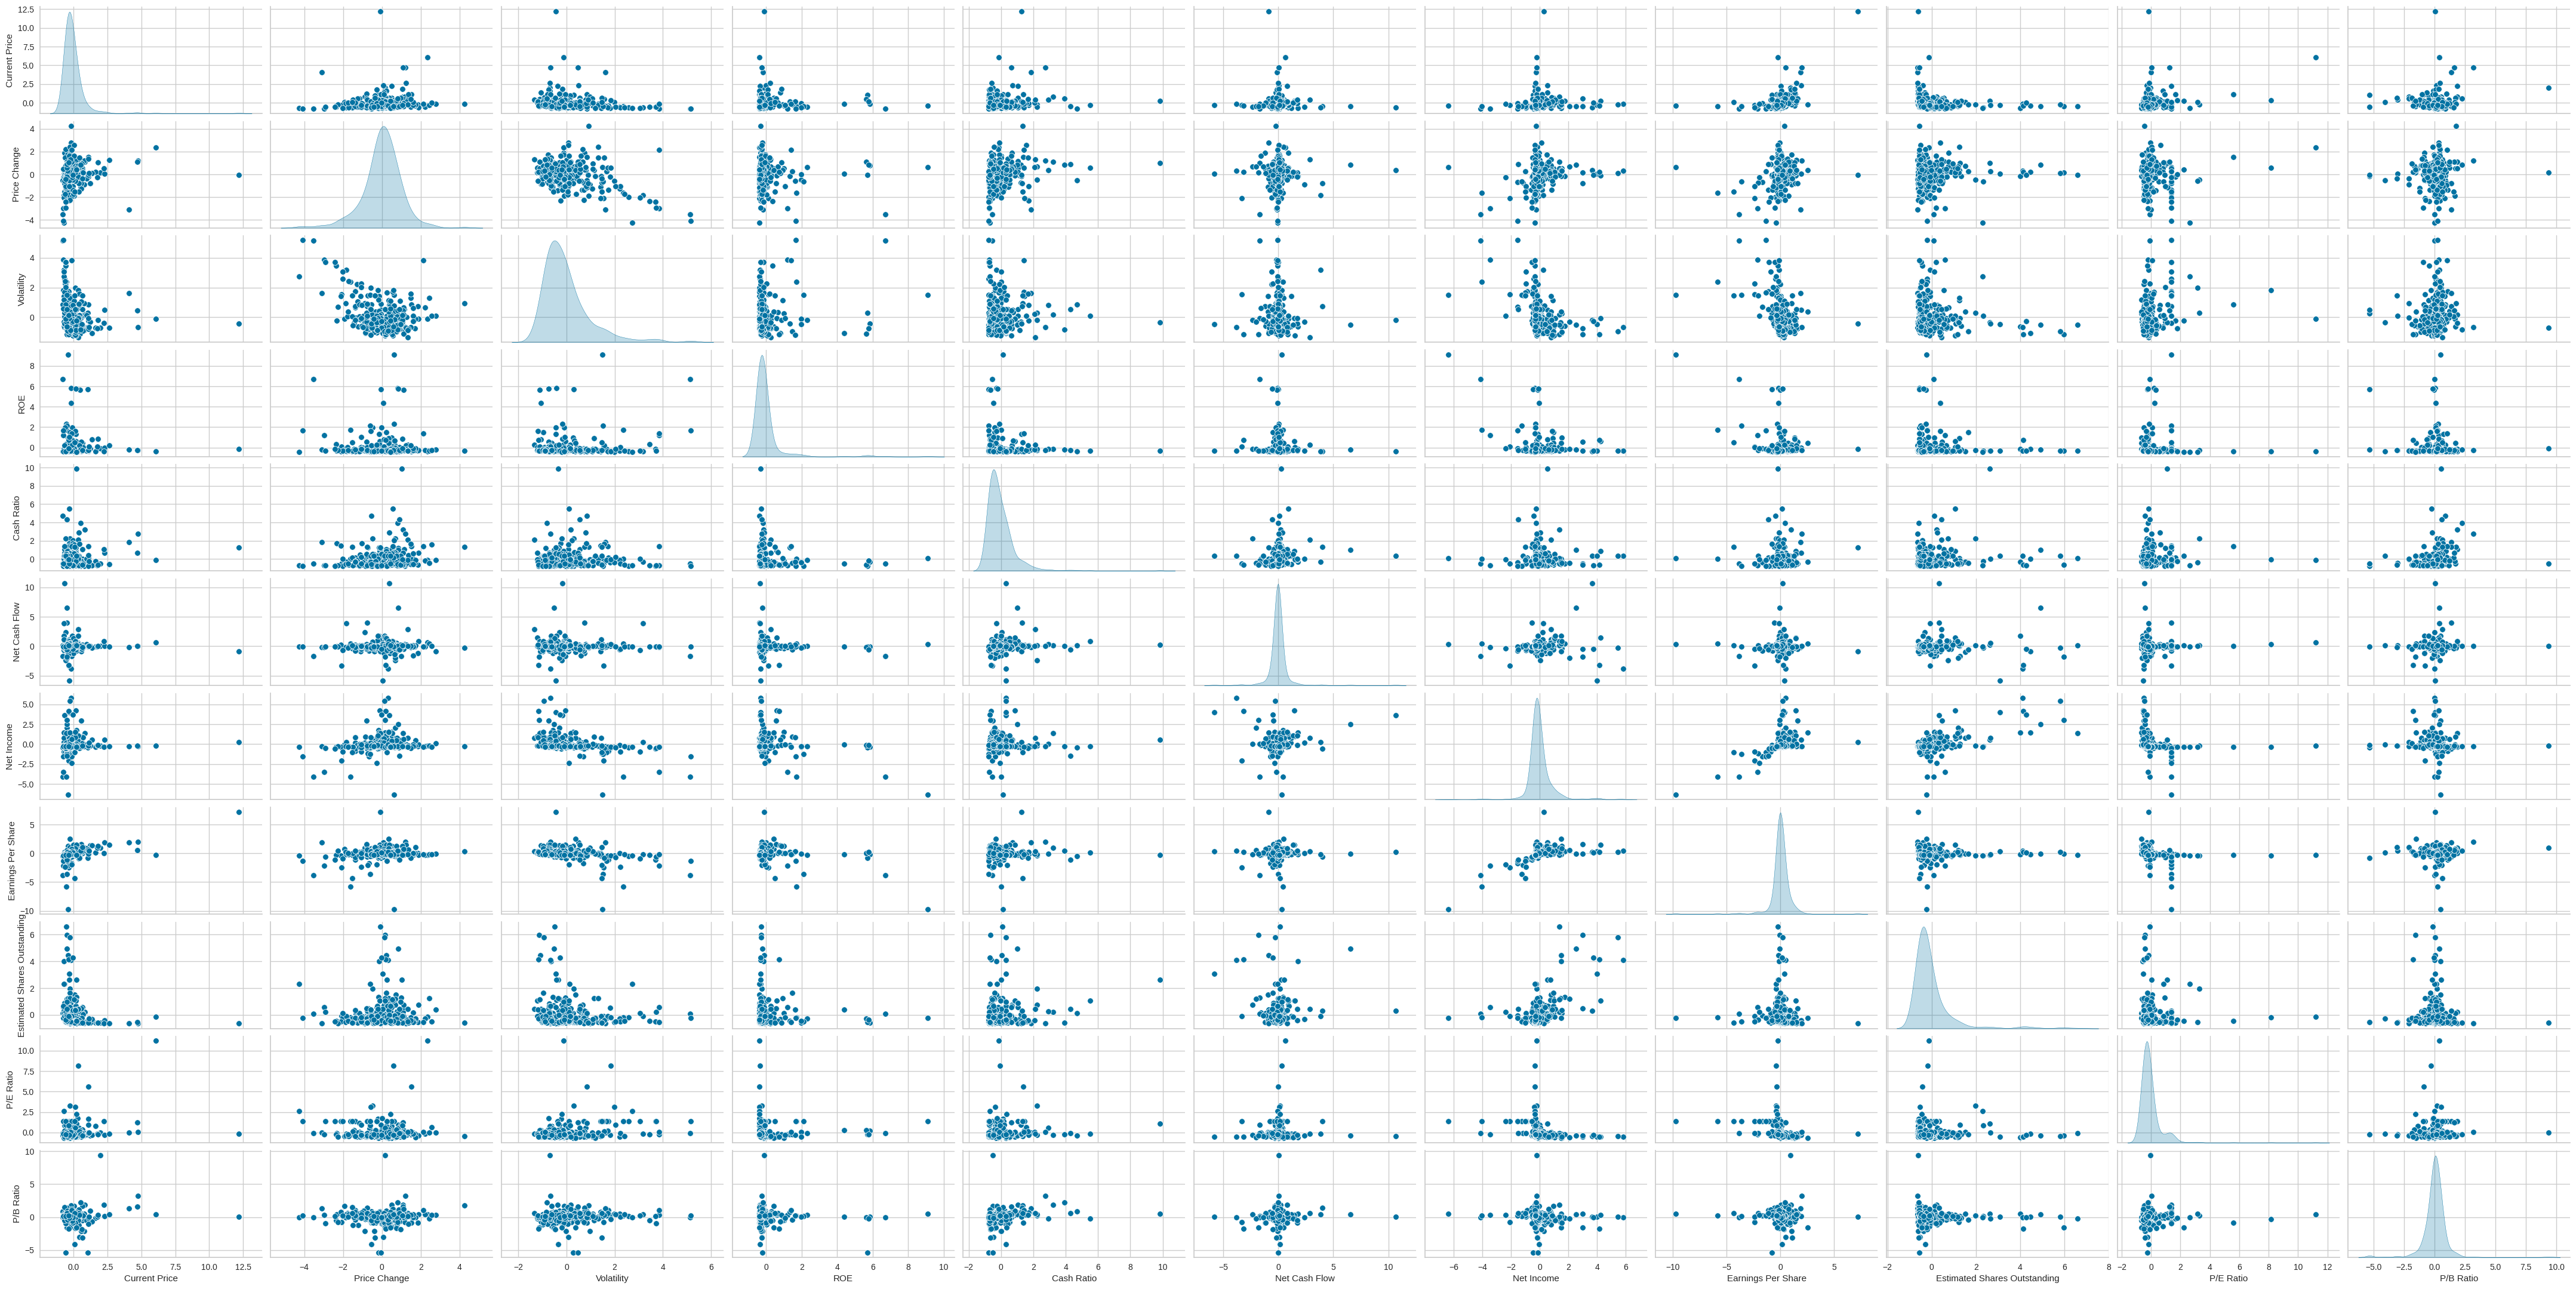

In [27]:
#create pairplot for scaled dataframe
sns.pairplot(subset_scaled_df, height=2,aspect=2 , diag_kind='kde')
plt.show()

In [28]:
#print average distortions for range of kmeans models fitted to scaled dataset
clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2659465936501304
Number of Clusters: 4 	Average Distortion: 2.2106334639099248
Number of Clusters: 5 	Average Distortion: 2.128338996505974
Number of Clusters: 6 	Average Distortion: 2.0598763618226803
Number of Clusters: 7 	Average Distortion: 2.0246699618696655
Number of Clusters: 8 	Average Distortion: 1.9887592433275094
Number of Clusters: 9 	Average Distortion: 1.8929684909747697
Number of Clusters: 10 	Average Distortion: 1.8540958566681758


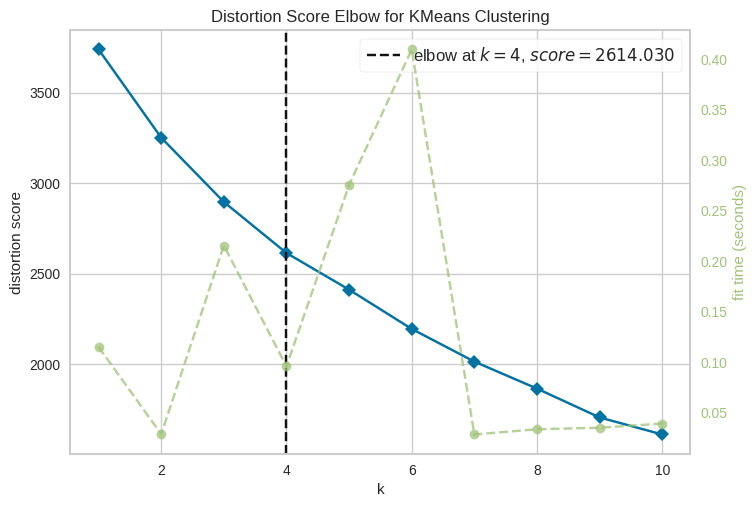

In [29]:
#fit KMeans model and use visualizaer to indicate optimal K value
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.45797710447228496)
For n_clusters = 4, the silhouette score is 0.45017906939331087)
For n_clusters = 5, the silhouette score is 0.4599352800740646)
For n_clusters = 6, the silhouette score is 0.3985379248608659)
For n_clusters = 7, the silhouette score is 0.3868475076242907)
For n_clusters = 8, the silhouette score is 0.3886929719130642)
For n_clusters = 9, the silhouette score is 0.40581042332267614)
For n_clusters = 10, the silhouette score is 0.18011528994705786)


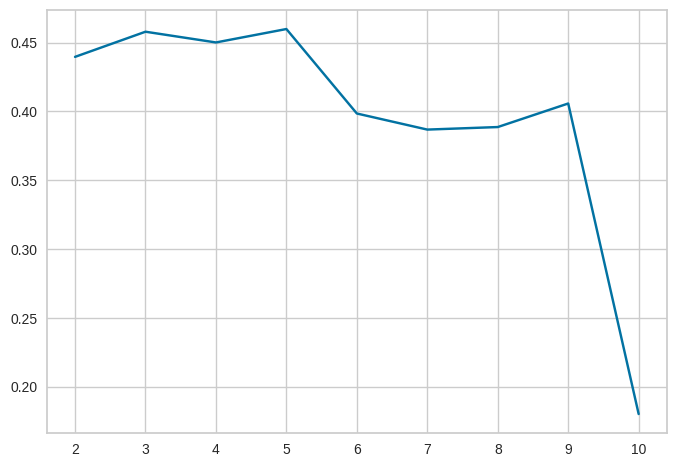

In [30]:
#fit KMeans model and provide silhouette scores for range of k clusters
sil_score = []
cluster_list = range(2, 11)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

#show scores in line graph
plt.plot(cluster_list, sil_score)
plt.show()

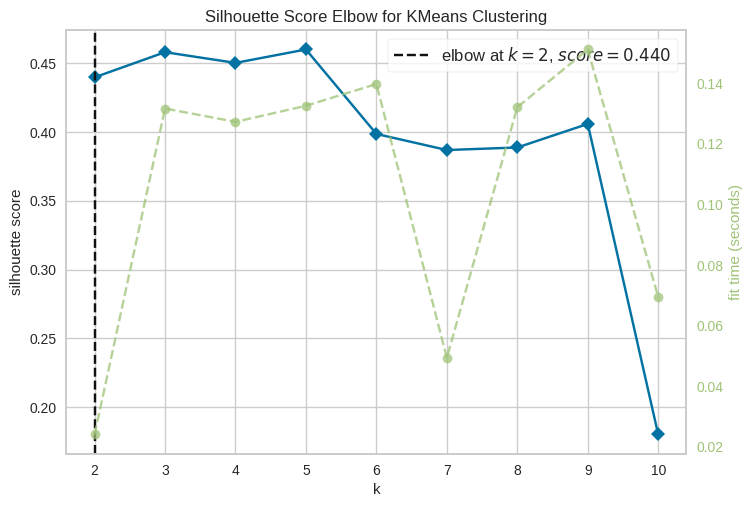

In [31]:
#fit KMeans model and use visualizaer to indicate optimal K value
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 11), metric="silhouette", timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

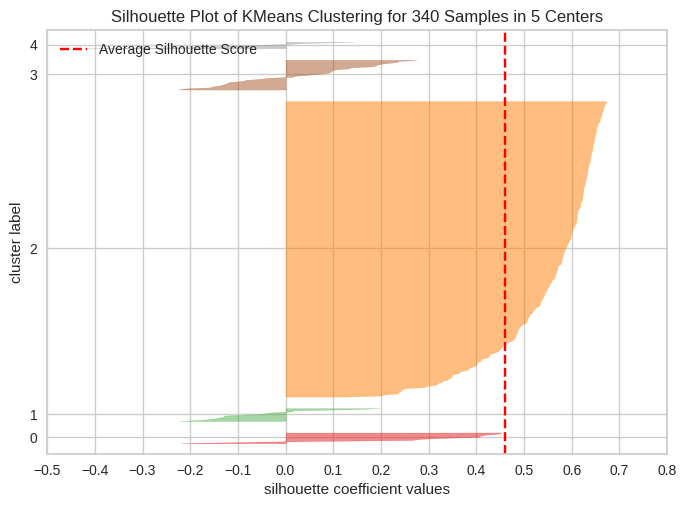

In [32]:
#find optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=42))
visualizer.fit(subset_scaled_df)
visualizer.show()
plt.show()

- Between the Elbow and Silhouette plots, the number of clusters with the best performance appears to be 5

In [33]:
#create kmeans cluster model
kmeans = KMeans(n_clusters=5, random_state=42)

#fit model to scaled dataset
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=42)

#### Cluster Profiling

In [34]:
# adding kmeans cluster labels to the original dataframe
df["KMeans_clusters"] = kmeans.labels_

In [35]:
#group dataset by kmeans cluster labels
cluster_profile = df.groupby("KMeans_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile["Count"] = (
    df.groupby("KMeans_clusters")["Current Price"].count().values
)

In [36]:
cluster_profile.style.highlight_max(color="lightblue", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
KMeans_clusters,,,,,,,,,,,,
0,50.477272,5.588148,1.141171,31.545455,64.181818,-2581727272.727273,14675545454.545454,4.490909,4012176129.000000,14.010093,-5.356393,11
1,81.418719,10.536341,1.578634,17.000000,367.538462,3857062692.307693,3129067846.153846,2.197692,1334755181.584615,65.639418,6.235848,13
2,73.769121,5.466467,1.392827,34.632143,55.710714,4183132.142857,1443269353.571429,3.629625,430217149.035393,24.132318,-3.203999,280
3,38.808966,-13.680395,2.938240,106.034483,55.551724,-189825655.172414,-3578126517.241379,-8.657586,463121182.880690,85.946813,1.888901,29
4,585.527134,7.752090,1.508020,17.571429,159.142857,210520428.571429,804590428.571429,14.410000,116080574.760000,118.763084,33.713020,7


In [37]:
# print the names of the companies in each cluster
for cl in df["KMeans_clusters"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df[df["KMeans_clusters"] == cl]["Security"].unique().to_list())
    print()

In cluster 2, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Allegion', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'BIOGEN IDEC Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 'Caterpillar

In [38]:
#print number of stocks within each sector for all of the clusters
for k in range(0,df['KMeans_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df[df['KMeans_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Financials                     3
Consumer Discretionary         2
Health Care                    2
Telecommunications Services    2
Consumer Staples               1
Energy                         1
Industrials                    0
Information Technology         0
Materials                      0
Real Estate                    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Health Care                    4
Information Technology         4
Consumer Discretionary         1
Consumer Staples               1
Energy                         1
Financials                     1
Telecommunications Services    1
Industrials                    0
Materials                      0
Real Estate                    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Industrial

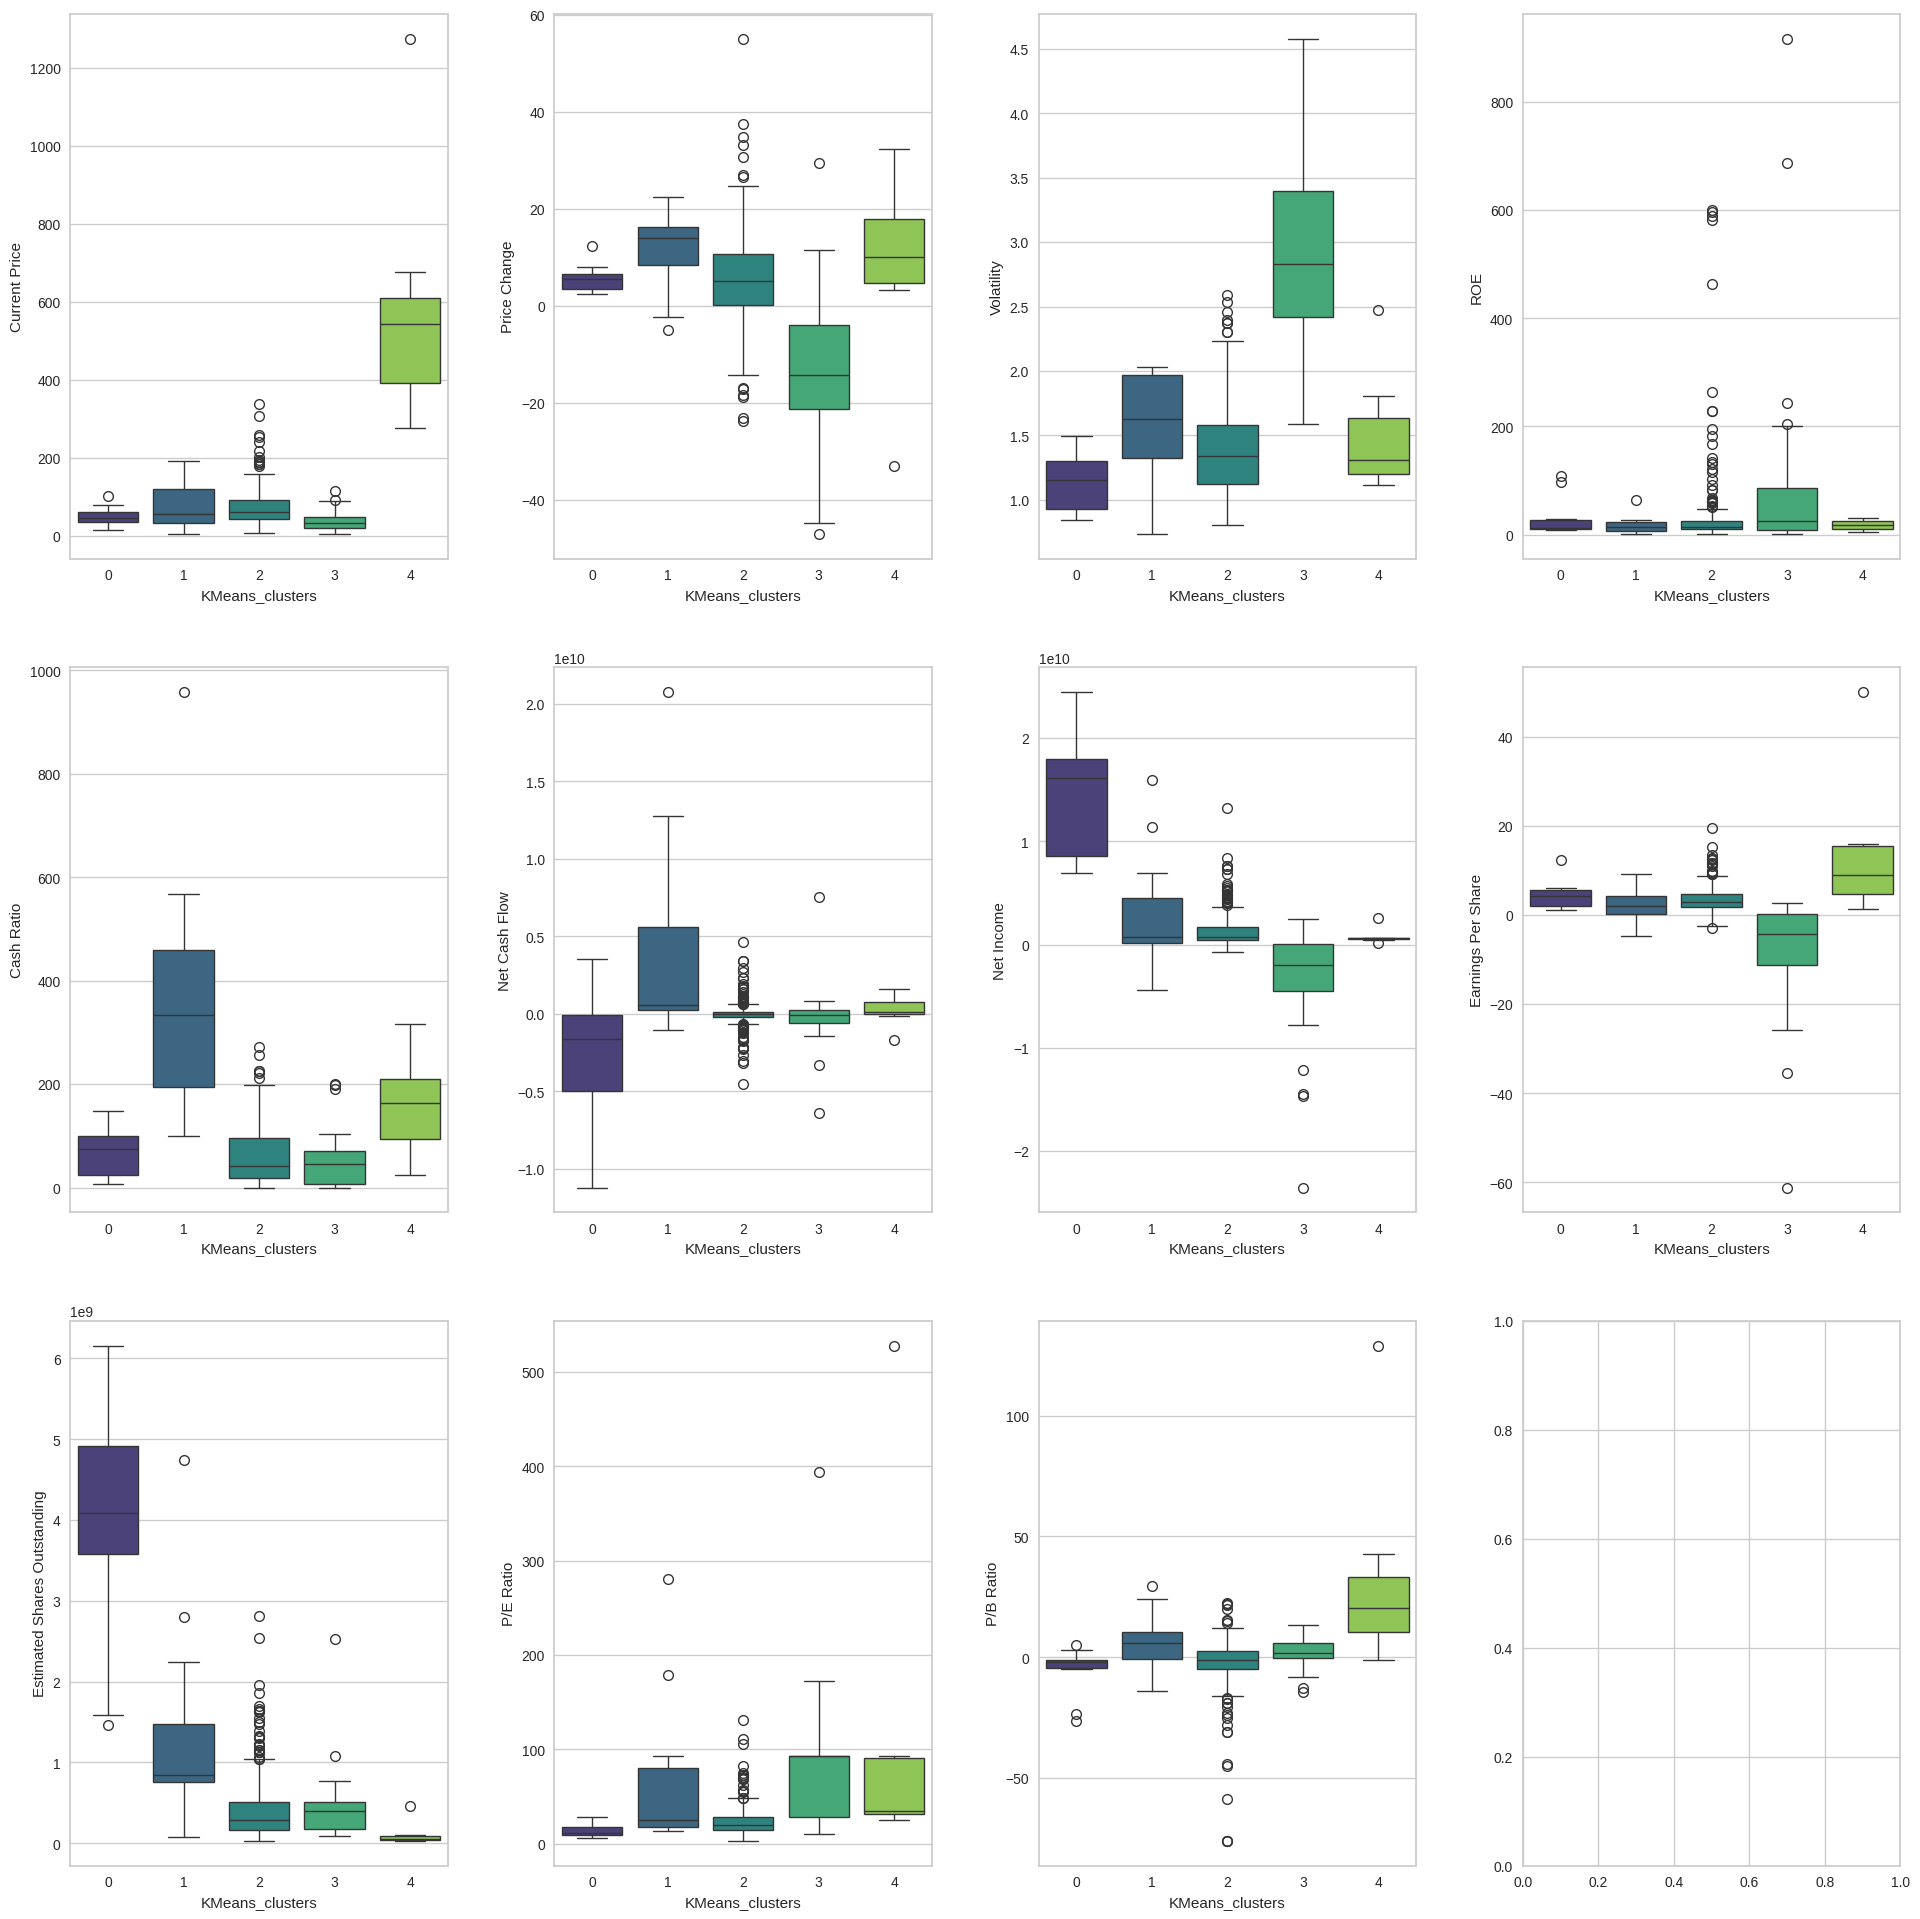

In [39]:
# show boxplots of numerical variables for each K-Means cluster
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df,
                y=df.columns[3+counter],
                x="KMeans_clusters",
                palette="viridis"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

### KMeans Clusters
**Cluster 0 - Large Market Capitalization / Dow Jones Industrial Average**
- 11 stocks, comprised mostly of stocks within the Financials, Health Care, Information Technology (IT), and Consumer Discretionary sectors
- Companies within this cluster have:
    - Low volatility
    - Most of the companies with the highest outflows of cash
    - The highest net incomes
    - The highest number of shares outstanding

**Cluster 1 - "Cash is King"**
- 13 stocks, comprised mostly of stocks within the Healthcare and IT sectors
- Companies within this cluster have:
    - Moderate volatility
    - Mostly profitable
    - Most of the highest cash ratios and cash inflows

**Cluster 2 - S&P 500 / Diversification**
- 280 stocks (~84% of all stocks in the dataset) drawn from all sectors present in the dataset
- Companies within this cluster have:
    - Low P/E ratios
    - Most of the outliers on negative P/B ratios

**Cluster 3 - "Ride the Energy Rollercoaster" portfolio / Growth mindset**
- 29 stocks, a vast majority of which are from the Energy sector
- Companies within this cluster have:
    - Low stock prices, but high ROE
    - High beta
    - Most of the most volatile stocks, especially those with outliers in price decreases
    - Mostly negative net incomes and earnings per share

**Cluster 4 - High Earnings for a High Price**
- 7 stocks, comprised mostly of stocks from the Health Care and Consumer Discretionary sectors
- Companies within this cluster have:
    - Most of stocks with the highest prices
    - Favorable cash ratios
    - The most favorable P/B ratios
    - Most of the highest earnings-per-share

## Hierarchical Clustering

In [40]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c,4)
            )
        )
        print(" ")
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9423.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8694.
 
Cophenetic correlation for Chebyshev distance and single linkage is 0.9063.
 
Cophenetic correlation for Chebyshev distance and complete linkage is 0.5989.
 
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338.
 
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127.
 
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259.
 
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925.
 
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247.
 
Cophenetic correlation for Mahalanobis distance and weighted linkage is 0.8708.
 
Cophenetic correlation for Cityblock dist

In [41]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9423, which is obtained with Euclidean distance and average linkage.


In [42]:
# list of linkage methods for euclidean distance metric
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print(
            "Cophenetic correlation for Euclidean distance and {} linkage is {}.".format(
                lm, round(c,4)
            )
        )
    print(" ")
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9423.
 
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9314.
 
Cophenetic correlation for Euclidean distance and ward linkage is 0.7101.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8694.
 


In [43]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9423, which is obtained with average linkage.


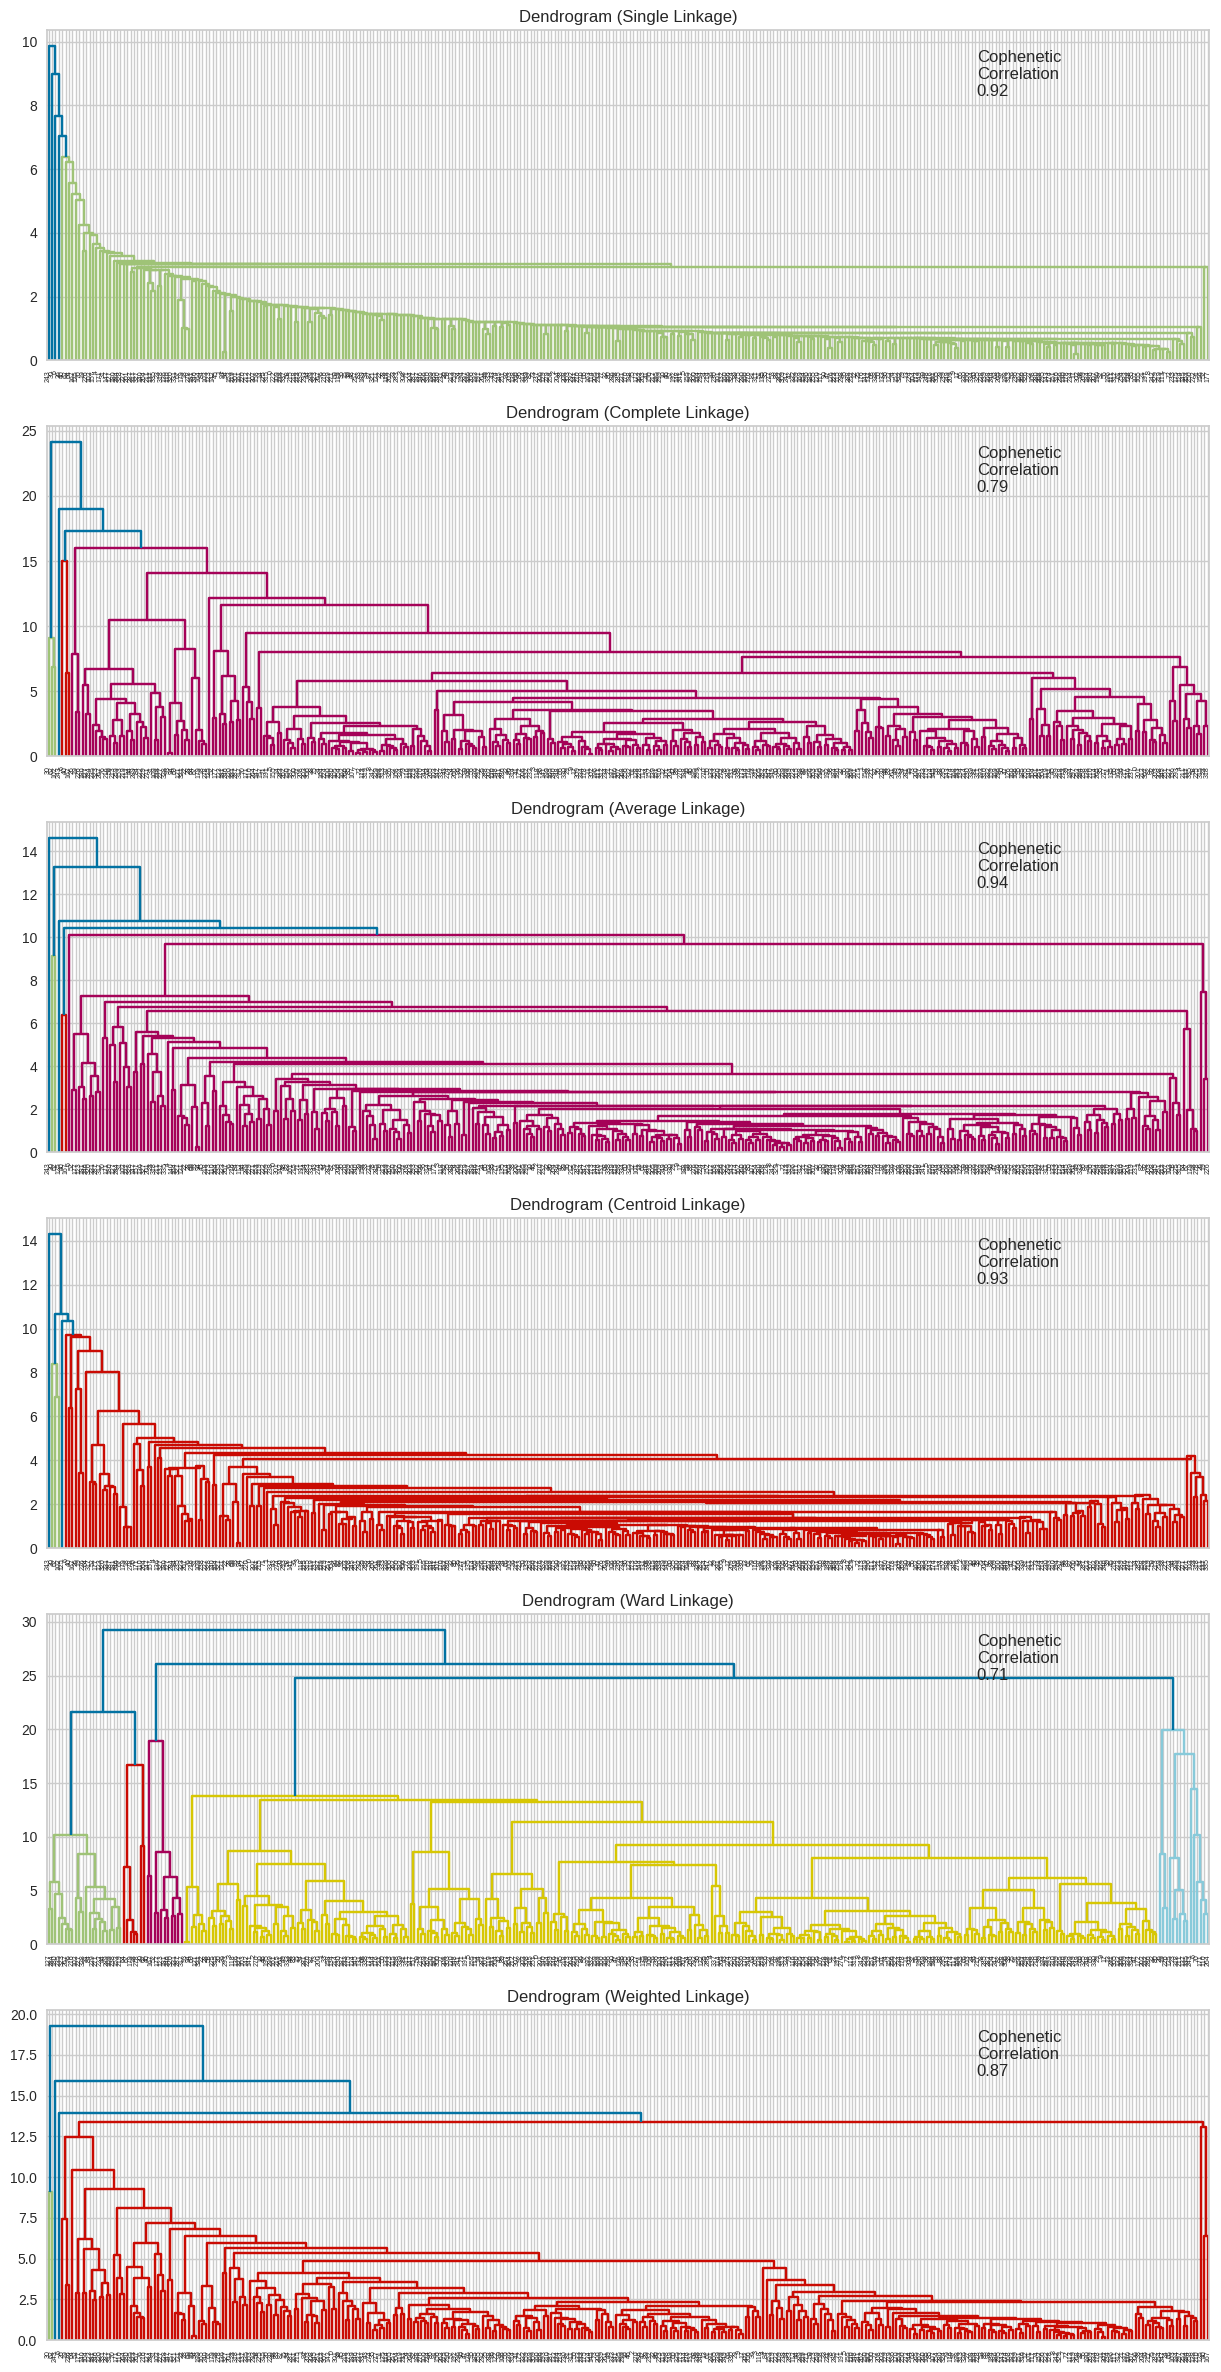

In [44]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

- The cophenetic correlation is highest for average and centroid linkage methods, but the dendrogram for average appears to provide better clusters
- 5 appears to be the appropriate number of clusters for the average linkage method

In [45]:
Z = linkage(subset_scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(subset_scaled_df))

In [46]:
hierarchy = AgglomerativeClustering(n_clusters=5, affinity='euclidean',  linkage='average')
hierarchy.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=5)

#### Cluster Profiling

In [47]:
df_hierarchy = df.copy()
df_hierarchy.drop("KMeans_clusters", axis=1, inplace=True)
df_hierarchy['HC_clusters'] = hierarchy.labels_

In [48]:
#group dataset by Hierarchical clusters
cluster_profile_h = df_hierarchy.groupby("HC_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile_h["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

#show dataframe with maximum values for each metric highlighted
cluster_profile_h.style.highlight_max(color="lightblue", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,77.884243,4.105986,1.516865,35.320359,66.775449,-32825817.365269,1535255703.592814,2.903308,559027333.145509,32.437511,-1.781988,334
1,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,2
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1
4,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1


- There are 2 clusters of one company, 2 clusters of two companies, and a single cluster of the remaining 334 companies
- The clustering of these companies does not solve the business problem at hand, because the clusters do not have enough variability

**In contrasts, the dendrogram for Ward linkage appears to provide better clustering, with 5 appearing to be the appropriate number of clusters**

In [49]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=5)

#### Cluster Profiling

In [50]:
subset_scaled_df["HC_clusters"] = HCmodel.labels_
df_hierarchy["HC_clusters"] = HCmodel.labels_

In [51]:
#group dataset by Hierarchical clusters
cluster_profile_h = df_hierarchy.groupby("HC_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile_h["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

#show dataframe with maximum values for each metric highlighted
cluster_profile_h.style.highlight_max(color="lightblue", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,326.198218,10.563242,1.642560,14.400000,309.466667,288850666.666667,864498533.333333,7.785333,544900261.301333,113.095334,19.142151,15
1,84.355716,3.854981,1.827670,633.571429,33.571429,-568400000.000000,-4968157142.857142,-10.841429,398169036.442857,42.284541,-11.589502,7
2,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,11
3,72.760400,5.213307,1.427078,25.603509,60.392982,79951512.280702,1538594322.807018,3.655351,446472132.228456,24.722670,-2.647194,285
4,36.440455,-16.073408,2.832884,57.500000,42.409091,-472834090.909091,-3161045227.272727,-8.005000,514367806.201818,85.555682,0.836839,22


In [52]:
# print the names of the companies in each cluster
for cl in df_hierarchy["HC_clusters"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df_hierarchy[df_hierarchy["HC_clusters"] == cl]["Security"].unique().to_list())
    print()

In cluster 3, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Analog Devices, Inc.', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'BIOGEN IDEC Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 

In [53]:
# print the number of stocks in each GICS sector for each cluster
for k in range(0,df_hierarchy['HC_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df_hierarchy[df_hierarchy['HC_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Health Care                    5
Information Technology         4
Consumer Discretionary         3
Consumer Staples               1
Real Estate                    1
Telecommunications Services    1
Energy                         0
Financials                     0
Industrials                    0
Materials                      0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Consumer Staples               2
Energy                         2
Consumer Discretionary         1
Financials                     1
Industrials                    1
Health Care                    0
Information Technology         0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Financials

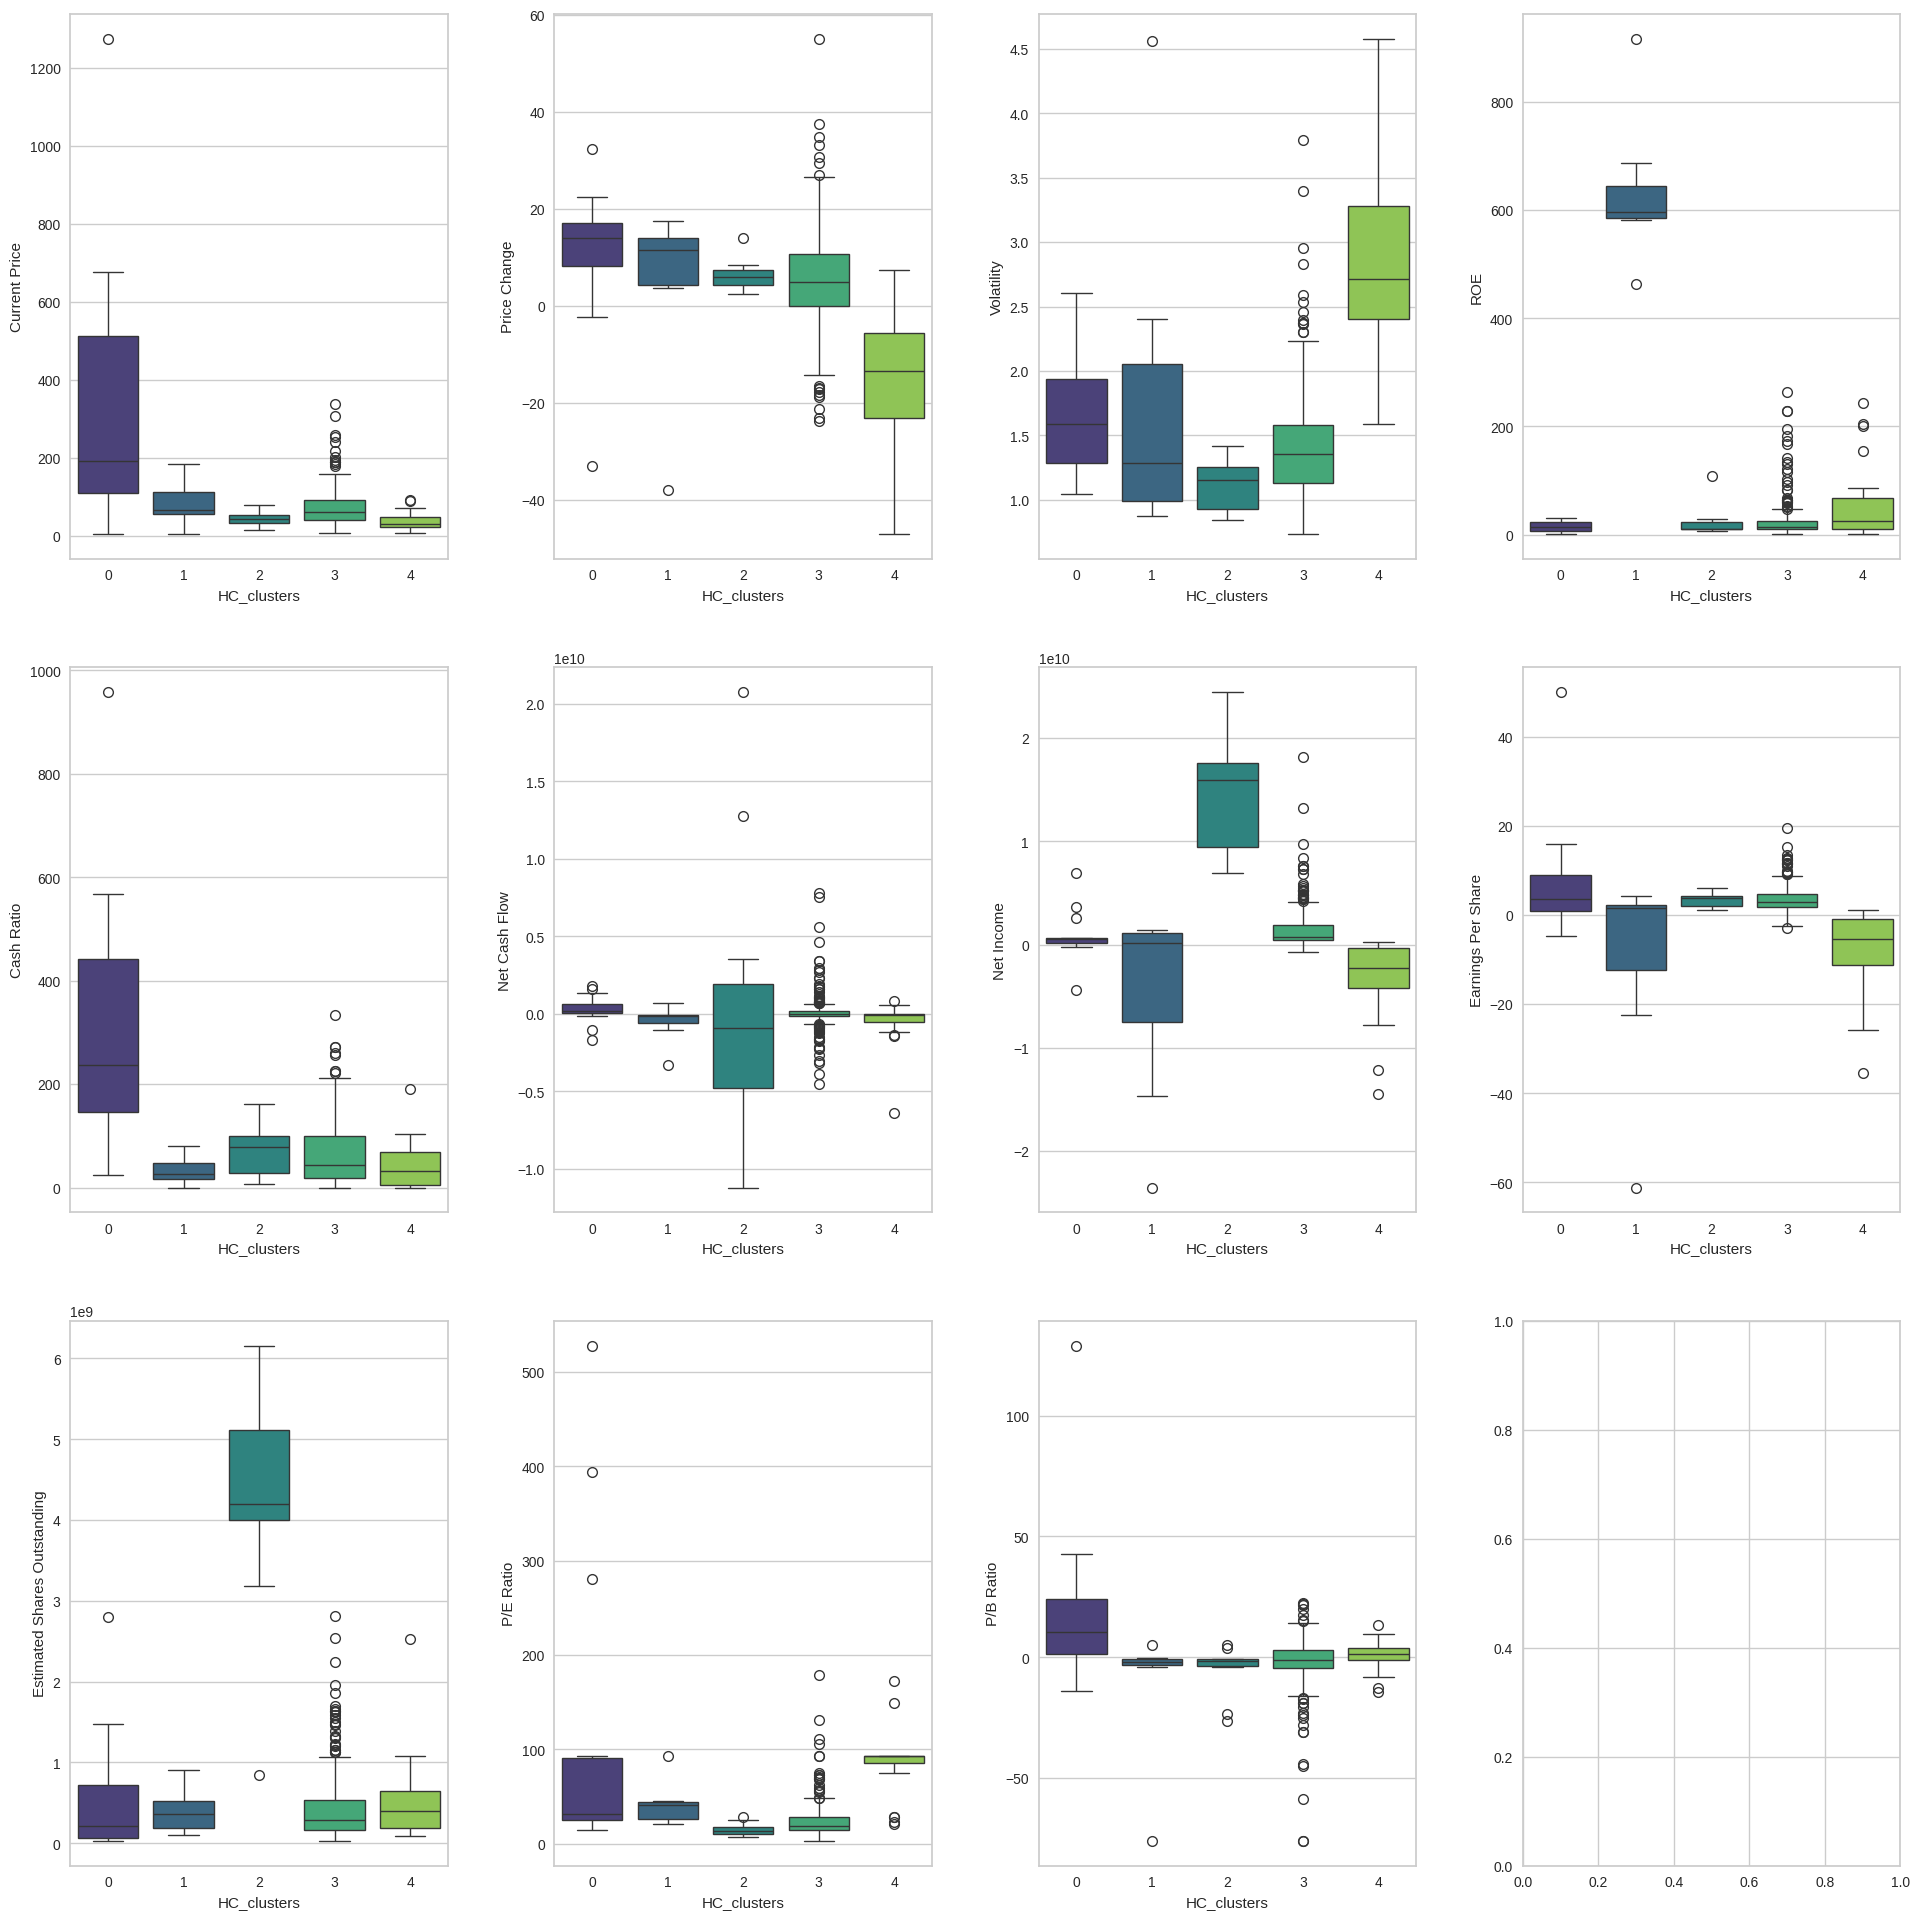

In [54]:
# show boxplots of numerical variables for each Hierarchical cluster
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df_hierarchy,
                y=df_hierarchy.columns[3+counter],
                x="HC_clusters",
                palette="viridis"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

### Hierarchical Clusters

**Cluster 0 - Growth for a Price**
- 15 stocks, comprised mostly of stocks within the Health Care, Information Technology (IT), and Consumer Discretionary sectors
- Companies within this cluster have:
    - Most of stocks with the highest prices
    - Significant outliers in price-to-equity ratio
    - The most favorable price-to-book (P/B) ratios
    - Most of the highest cash ratios

**Cluster 1 - Short-term Poor, Long-term Rich**
- 7 stocks, comprised mostly of stocks within the Consumer Staples and Energy sectors
- Companies within this cluster have:
    - The highest returns-on-equity
    - The lowest net incomes
    - Mostly negative earnings per share

**Cluster 2- DJIA**
- 11 stocks, comprised mostly of stocks within the Financials and Telecommunications sectors
- Companies within this cluster have:
    - Most of the companies with the highest inflows and outflows of cash
    - The highest net incomes
    - The highest number of shares outstanding

**Cluster 3 - Diversification**
- 285 stocks (~84% of all stocks in the dataset) drawn from all sectors present in the dataset
- Companies within this cluster have:
    - Most of outliers in price increases and some of the outliers in price decreases
    - Some of outliers in cash inflows and outflows
    - Most of the outliers in P/B ratio

**Cluster 4 - Energy-specific portfolio**
- 22 stocks, a vast majority of which are in the Energy sector
- Companies within this cluster have:
    - Most of the most volatile stocks, especially those with outliers in price decreases
    - Mostly negative net incomes and earnings per share

## K-means vs Hierarchical Clustering

**Which clustering technique took less time for execution?**
- Both the KMeans model and the Agglomerative Clustering model fit the dataset within ~0.1s

**Which clustering technique gave you more distinct clusters, or are they the same? How many observations are there in the similar clusters of both algorithms?**
- Both algorithms give similar clusters, with a single cluster of a majority of the stocks and the remaining four clusters containing 7-29 stocks

**How many clusters are obtained as the appropriate number of clusters from both algorithms?**
- For both algorithms, 5 clusters provided distinct clusters with sufficient observations in each to reasonably differentiate which "type" of stock is representative of the cluster

**Differences or similarities in the cluster profiles from both the clustering techniques**
- Both algorithms yielded similar clusters based on the outliers within the 11 variables

## Actionable Insights and Recommendations

- Trade&Ahead should first identify the financial goals, risk tolerance, and investment behaviors of their clilents, then recommend a cluster as a potential portfolio of stocks which will fit these needs
- However, many of these clusters, based on the characteristics of the stocks within them, are essentially substitutes for standard indexes, such as the Dow Jones Industrial Average and the S&P 500, which could more easily achieve these goals
- Alternatively, Trade&Ahead could use these clusters as an starting point for further financial statement analysis, particularly which individual stocks do not fit the "profile" of the cluster
    - Assuming selecting individual stocks is a component of a client's investment strategy, Trade&Ahead may then be able to identify stocks which should outperform its peers (i.e., price will rise = buy recommendation) or likely fall behind its peers (i.e., price will fall = sell recommendation)